In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(tidyverse)
    library(gprofiler2)
    library(msigdbr)
    library(fgsea)
    library(edgeR)
    library(clusterProfiler)

})
sce <- readRDS('../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_tumor_D1220.rds')
sce$leiden <- paste0("C0", sce$leiden)

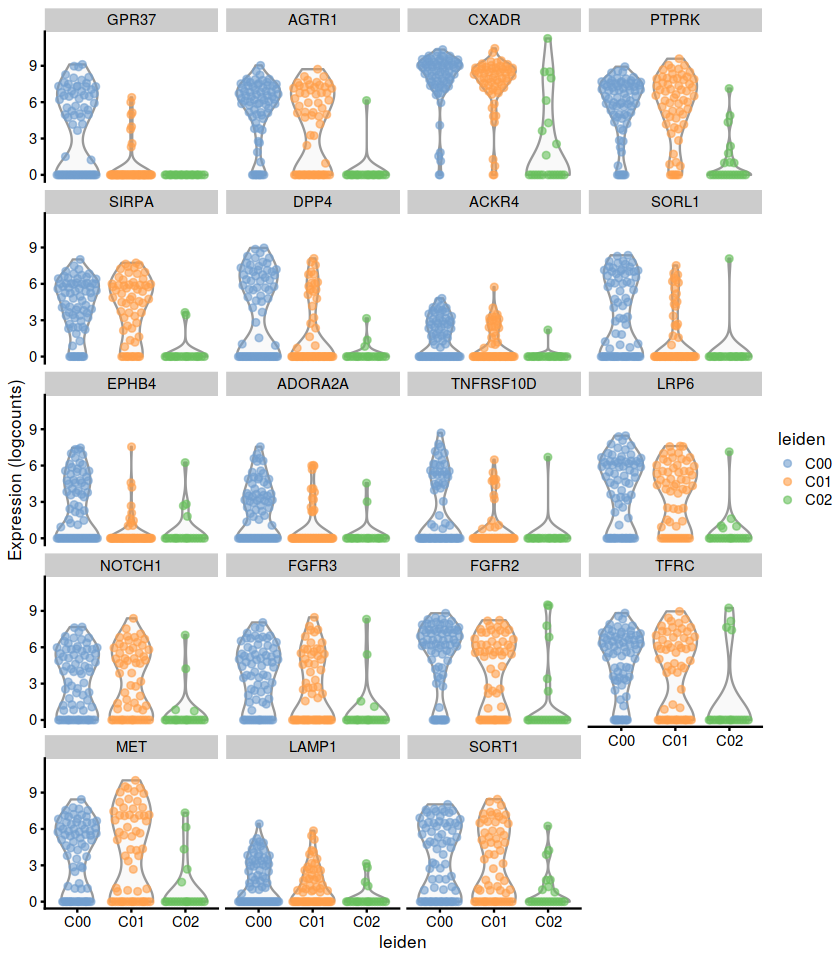

In [51]:
plotExpression(sce, features = deC00receptor$gene , x = 'leiden', colour_by = "leiden", ncol = 4)

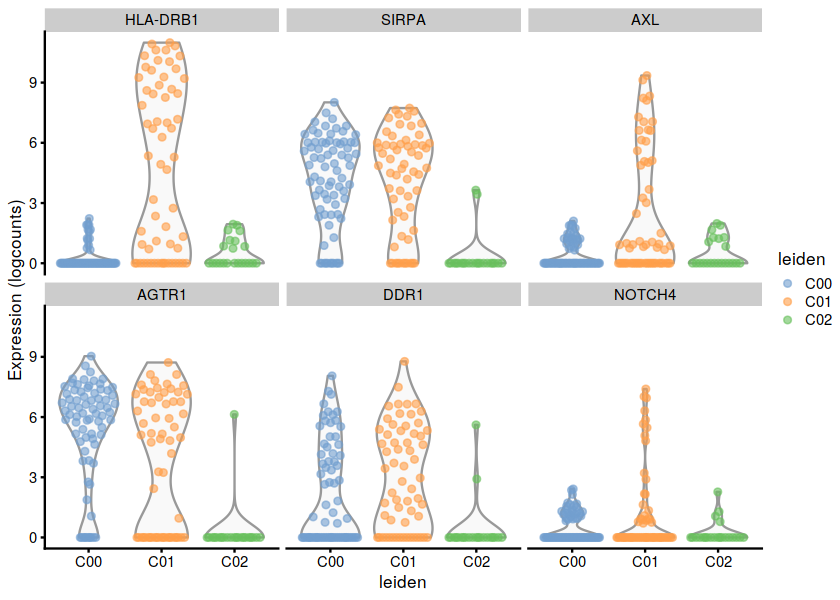

In [55]:
options(repr.plot.height = 5)

plotExpression(sce, features = deC01receptor$gene , x = 'leiden', colour_by = "leiden", ncol = 3)

In [2]:
topInteract_clean <- readr::read_tsv("../03_cell_interaction/out/topInteraction_cellphonedb_clean.tsv" )


Rows: 43766 Columns: 24

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (14): id_cp_interaction, cluster_pair, interacting_pair, partner_a, part...
dbl  (6): pvalue, mean, fractionExprLigand, meanExprLigand, fractionExprRece...
lgl  (4): secreted, receptor_a, receptor_b, is_integrin


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [24]:
topInteract_CAF2tumor <- topInteract_clean %>% 
   mutate(LR = paste0(ligand, "-", receptor)) %>%
   filter(grepl("CAF", sending )) %>%  
   filter(grepl("^HCC|^Hepa", receiver)) %>% 
   filter(grepl("D20171220", receiver)) %>%
   mutate(group = "Tumor")

In [14]:
deC00 <- readr::read_tsv(file = "./out/DE_edgeR_C00.tsv") %>% filter(logFC > 1)
deC01 <- readr::read_tsv(file = "./out/DE_edgeR_C01.tsv") %>% filter(logFC > 1)
deC02 <- readr::read_tsv(file = "./out/DE_edgeR_C02.tsv") %>% filter(logFC > 1)

Rows: 19814 Columns: 12

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, Geneid, Chr, Symbol, Biotype
dbl (6): Length, logFC, logCPM, F, PValue, FDR
lgl (1): highly_variable


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 19814 Columns: 12

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, Geneid, Chr, Symbol, Biotype
dbl (6): Length, logFC, logCPM, F, PValue, FDR
lgl (1): highly_variable


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 19814 Columns: 12

── Column specification ───────

In [30]:
deC00receptor <- deC00[deC00$gene %in% topInteract_CAF2tumor$receptor,]

In [31]:
deC01receptor <- deC01[deC01$gene %in% topInteract_CAF2tumor$receptor,]

In [36]:
deC01receptor

gene,Geneid,Chr,Length,Symbol,Biotype,highly_variable,logFC,logCPM,F,PValue,FDR
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HLA-DRB1,ENSG00000196126.9,chr6,1304,HLA-DRB1,protein_coding,TRUE,2.887448,6.636435,53.311486,7.692364e-12,8.965677e-10
SIRPA,ENSG00000198053.10,chr20,5068,SIRPA,protein_coding,FALSE,1.256246,7.159583,18.589747,2.606488e-05,3.606491e-04
AXL,ENSG00000167601.10,chr19,5154,AXL,protein_coding,FALSE,1.677218,6.303109,16.503270,7.111859e-05,8.402766e-04
AGTR1,ENSG00000144891.16,chr3,3478,AGTR1,protein_coding,TRUE,1.141223,7.312568,13.029190,3.926664e-04,3.399224e-03
DDR1,ENSG00000204580.10,chr6,9122,DDR1,protein_coding,FALSE,1.130093,6.791251,8.127744,4.843539e-03,2.585395e-02
NOTCH4,ENSG00000204301.6,chr6,9748,NOTCH4,protein_coding,FALSE,1.051691,6.110916,6.125683,1.420359e-02,6.084972e-02


In [37]:
topInteract_CAF2tumor[topInteract_CAF2tumor$receptor %in% 'FGFR1',]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR,group
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>


In [32]:
setdiff(deC01receptor$gene, deC00receptor$gene)

[1] "HLA-DRB1" "AXL"      "DDR1"     "NOTCH4"

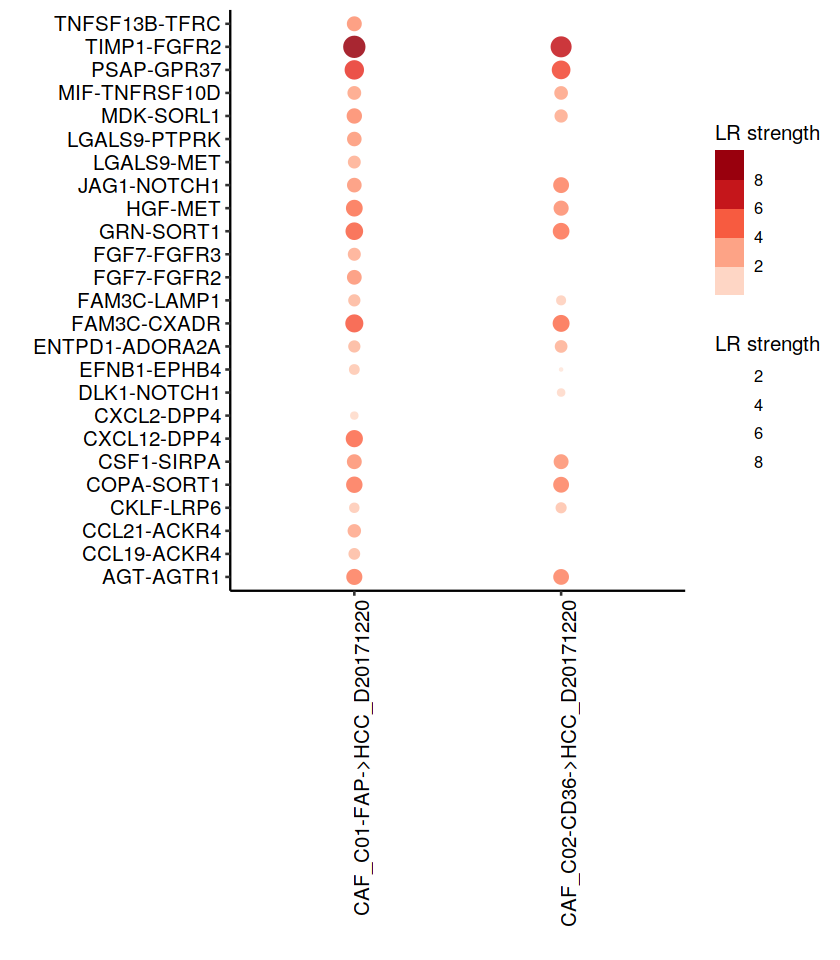

In [47]:
plotInteractDF <- rbind(topInteract_CAF2tumor[topInteract_CAF2tumor$receptor %in% deC00receptor$gene,]) 
options(repr.plot.height = 8)
p1 <- plotInteractDF %>% 
   # filter(grepl("^Mac", receiver)) %>%
 mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    ggplot( aes(x = paste0(sending, "->", receiver), y = LR)) +
    geom_point(aes(size = mean,  fill = mean, color = mean), shape = 21, alpha = .85,  stroke = .001 ) +
    scale_fill_distiller(palette = "Reds", direction = 1) + 
    scale_color_distiller(palette = "Reds", direction = 1) + 
    #scale_size(range = c(0, 10)) + 
    guides(fill = guide_colorsteps(title = 'LR strength'),color = guide_colorsteps(title = 'LR strength'), size = guide_legend(title = 'LR strength')) +
    ylab("") + xlab("") +
    ggpubr::theme_pubr() + theme(legend.position = 'right', axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) 
p1

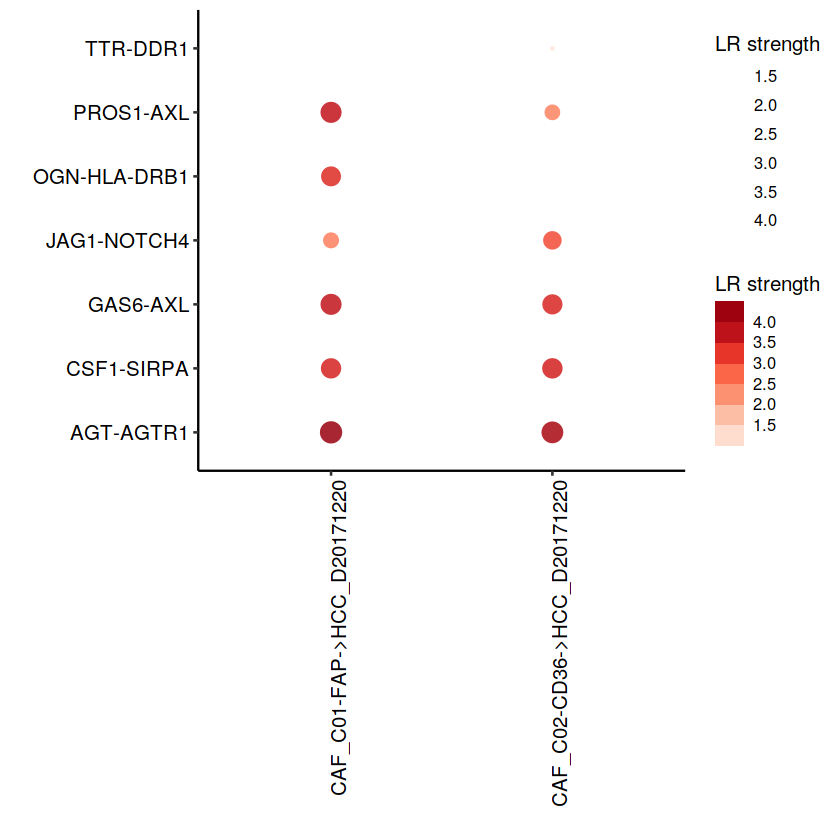

In [42]:
plotInteractDF <- rbind(topInteract_CAF2tumor[topInteract_CAF2tumor$receptor %in% deC01receptor$gene,]) 
p2 <- plotInteractDF %>% 
   # filter(grepl("^Mac", receiver)) %>%
 mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    ggplot( aes(x = paste0(sending, "->", receiver), y = LR)) +
    geom_point(aes(size = mean,  fill = mean, color = mean), shape = 21, alpha = .85,  stroke = .001 ) +
    scale_fill_distiller(palette = "Reds", direction = 1) + 
    scale_color_distiller(palette = "Reds", direction = 1) + 
    #scale_size(range = c(0, 10)) + 
    guides(fill = guide_colorsteps(title = 'LR strength'),color = guide_colorsteps(title = 'LR strength'), size = guide_legend(title = 'LR strength')) +
    ylab("") + xlab("") +
    ggpubr::theme_pubr() + theme(legend.position = 'right', axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) 
p2

In [34]:
topInteract_CAF2tumor[topInteract_CAF2tumor$receptor %in% deC00receptor$gene,]

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR,group
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CPI-SS00E68BB92,CAF_C01.FAP|HCC_D20171220,0,2.763,FGF7_FGFR3,simple:P21781,simple:P22607,FGF7,FGFR3,TRUE,⋯,CAF_C01-FAP,FGF7,HCC_D20171220,FGFR3,0.4310345,2.6560221,0.6075949,2.2305995,FGF7-FGFR3,Tumor
CPI-SS0E928B8C8,CAF_C01.FAP|HCC_D20171220,0,3.456,FGF7_FGFR2,simple:P21781,simple:P21802,FGF7,FGFR2,TRUE,⋯,CAF_C01-FAP,FGF7,HCC_D20171220,FGFR2,0.4310345,2.6560221,0.7088608,3.1392480,FGF7-FGFR2,Tumor
CPI-SS00AEC3818,CAF_C01.FAP|HCC_D20171220,0,2.335,CCL19_ACKR4,simple:Q99731,simple:Q9NPB9,CCL19,ACKR4,TRUE,⋯,CAF_C01-FAP,CCL19,HCC_D20171220,ACKR4,0.4310345,4.6659913,0.4177215,1.0779251,CCL19-ACKR4,Tumor
CPI-SS0ECD9BB5E,CAF_C01.FAP|HCC_D20171220,0,2.931,CCL21_ACKR4,simple:O00585,simple:Q9NPB9,CCL21,ACKR4,TRUE,⋯,CAF_C01-FAP,CCL21,HCC_D20171220,ACKR4,0.6551724,6.1823880,0.4177215,1.0779251,CCL21-ACKR4,Tumor
CPI-SS05996C8FD,CAF_C01.FAP|HCC_D20171220,0,4.085,AGT_AGTR1,simple:P01019,simple:P30556,AGT,AGTR1,TRUE,⋯,CAF_C01-FAP,AGT,HCC_D20171220,AGTR1,0.8620690,4.9079180,0.6645570,3.6461902,AGT-AGTR1,Tumor
CPI-SS0735F5C3A,CAF_C01.FAP|HCC_D20171220,0,8.007,TIMP1_FGFR2,simple:P01033,simple:P21802,TIMP1,FGFR2,TRUE,⋯,CAF_C01-FAP,TIMP1,HCC_D20171220,FGFR2,1.0000000,13.2940408,0.7088608,3.1392480,TIMP1-FGFR2,Tumor
CPI-SS068C129D6,CAF_C01.FAP|HCC_D20171220,0,3.513,CSF1_SIRPA,simple:P09603,simple:P78324,CSF1,SIRPA,TRUE,⋯,CAF_C01-FAP,CSF1,HCC_D20171220,SIRPA,0.6551724,3.4917919,0.7341772,2.7730855,CSF1-SIRPA,Tumor
CPI-SS0CDAC688B,CAF_C01.FAP|HCC_D20171220,0,1.543,CXCL2_DPP4,simple:P19875,simple:P27487,CXCL2,DPP4,TRUE,⋯,CAF_C01-FAP,CXCL2,HCC_D20171220,DPP4,0.3275862,1.1672280,0.4430380,1.9788232,CXCL2-DPP4,Tumor
CPI-SS059EEFDC6,CAF_C01.FAP|HCC_D20171220,0,3.049,MIF_TNFRSF10D,simple:P14174,simple:Q9UBN6,MIF,TNFRSF10D,TRUE,⋯,CAF_C01-FAP,MIF,HCC_D20171220,TNFRSF10D,0.9827586,6.4215966,0.3164557,1.2212532,MIF-TNFRSF10D,Tumor


In [33]:
topInteract_CAF2tumor[topInteract_CAF2tumor$receptor %in% deC01receptor$gene,]

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR,group
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CPI-SS05996C8FD,CAF_C01.FAP|HCC_D20171220,0,4.085,AGT_AGTR1,simple:P01019,simple:P30556,AGT,AGTR1,TRUE,⋯,CAF_C01-FAP,AGT,HCC_D20171220,AGTR1,0.8620690,4.9079180,0.6645570,3.6461902,AGT-AGTR1,Tumor
CPI-SS0837E9F59,CAF_C01.FAP|HCC_D20171220,0,2.472,JAG1_NOTCH4,simple:P78504,simple:Q99466,JAG1,NOTCH4,FALSE,⋯,CAF_C01-FAP,JAG1,HCC_D20171220,NOTCH4,0.8448276,3.4190129,0.3544304,0.3614118,JAG1-NOTCH4,Tumor
CPI-SS068C129D6,CAF_C01.FAP|HCC_D20171220,0,3.513,CSF1_SIRPA,simple:P09603,simple:P78324,CSF1,SIRPA,TRUE,⋯,CAF_C01-FAP,CSF1,HCC_D20171220,SIRPA,0.6551724,3.4917919,0.7341772,2.7730855,CSF1-SIRPA,Tumor
CPI-SS0C85BC9AF,CAF_C01.FAP|HCC_D20171220,0,3.723,PROS1_AXL,simple:P07225,simple:P30530,PROS1,AXL,TRUE,⋯,CAF_C01-FAP,PROS1,HCC_D20171220,AXL,0.9137931,6.1179979,0.4303797,0.8685292,PROS1-AXL,Tumor
CPI-SS05996C8FD,CAF_C02.CD36|HCC_D20171220,0,3.932,AGT_AGTR1,simple:P01019,simple:P30556,AGT,AGTR1,TRUE,⋯,CAF_C02-CD36,AGT,HCC_D20171220,AGTR1,0.7172414,4.5585893,0.6645570,3.6461902,AGT-AGTR1,Tumor
CPI-SS00D3CD86E,CAF_C02.CD36|HCC_D20171220,0,1.323,TTR_DDR1,simple:P02766,simple:Q08345,TTR,DDR1,TRUE,⋯,CAF_C02-CD36,TTR,HCC_D20171220,DDR1,0.4045977,0.8651406,0.5443038,1.3596406,TTR-DDR1,Tumor
CPI-SS0837E9F59,CAF_C02.CD36|HCC_D20171220,0,3.031,JAG1_NOTCH4,simple:P78504,simple:Q99466,JAG1,NOTCH4,FALSE,⋯,CAF_C02-CD36,JAG1,HCC_D20171220,NOTCH4,0.8758621,4.4078184,0.3544304,0.3614118,JAG1-NOTCH4,Tumor
CPI-SS068C129D6,CAF_C02.CD36|HCC_D20171220,0,3.534,CSF1_SIRPA,simple:P09603,simple:P78324,CSF1,SIRPA,TRUE,⋯,CAF_C02-CD36,CSF1,HCC_D20171220,SIRPA,0.6735632,3.5235716,0.7341772,2.7730855,CSF1-SIRPA,Tumor
CPI-SS0C85BC9AF,CAF_C02.CD36|HCC_D20171220,0,2.421,PROS1_AXL,simple:P07225,simple:P30530,PROS1,AXL,TRUE,⋯,CAF_C02-CD36,PROS1,HCC_D20171220,AXL,0.6482759,3.6208873,0.4303797,0.8685292,PROS1-AXL,Tumor


In [26]:
topInteract_CAF2tumor[topInteract_CAF2tumor$receptor %in% deC01$gene,]

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR,group
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CPI-SS05996C8FD,CAF_C01.FAP|HCC_D20171220,0,4.085,AGT_AGTR1,simple:P01019,simple:P30556,AGT,AGTR1,TRUE,⋯,CAF_C01-FAP,AGT,HCC_D20171220,AGTR1,0.8620690,4.9079180,0.6645570,3.6461902,AGT-AGTR1,Tumor
CPI-SS0837E9F59,CAF_C01.FAP|HCC_D20171220,0,2.472,JAG1_NOTCH4,simple:P78504,simple:Q99466,JAG1,NOTCH4,FALSE,⋯,CAF_C01-FAP,JAG1,HCC_D20171220,NOTCH4,0.8448276,3.4190129,0.3544304,0.3614118,JAG1-NOTCH4,Tumor
CPI-SS068C129D6,CAF_C01.FAP|HCC_D20171220,0,3.513,CSF1_SIRPA,simple:P09603,simple:P78324,CSF1,SIRPA,TRUE,⋯,CAF_C01-FAP,CSF1,HCC_D20171220,SIRPA,0.6551724,3.4917919,0.7341772,2.7730855,CSF1-SIRPA,Tumor
CPI-SS0C85BC9AF,CAF_C01.FAP|HCC_D20171220,0,3.723,PROS1_AXL,simple:P07225,simple:P30530,PROS1,AXL,TRUE,⋯,CAF_C01-FAP,PROS1,HCC_D20171220,AXL,0.9137931,6.1179979,0.4303797,0.8685292,PROS1-AXL,Tumor
CPI-SS05996C8FD,CAF_C02.CD36|HCC_D20171220,0,3.932,AGT_AGTR1,simple:P01019,simple:P30556,AGT,AGTR1,TRUE,⋯,CAF_C02-CD36,AGT,HCC_D20171220,AGTR1,0.7172414,4.5585893,0.6645570,3.6461902,AGT-AGTR1,Tumor
CPI-SS00D3CD86E,CAF_C02.CD36|HCC_D20171220,0,1.323,TTR_DDR1,simple:P02766,simple:Q08345,TTR,DDR1,TRUE,⋯,CAF_C02-CD36,TTR,HCC_D20171220,DDR1,0.4045977,0.8651406,0.5443038,1.3596406,TTR-DDR1,Tumor
CPI-SS0837E9F59,CAF_C02.CD36|HCC_D20171220,0,3.031,JAG1_NOTCH4,simple:P78504,simple:Q99466,JAG1,NOTCH4,FALSE,⋯,CAF_C02-CD36,JAG1,HCC_D20171220,NOTCH4,0.8758621,4.4078184,0.3544304,0.3614118,JAG1-NOTCH4,Tumor
CPI-SS068C129D6,CAF_C02.CD36|HCC_D20171220,0,3.534,CSF1_SIRPA,simple:P09603,simple:P78324,CSF1,SIRPA,TRUE,⋯,CAF_C02-CD36,CSF1,HCC_D20171220,SIRPA,0.6735632,3.5235716,0.7341772,2.7730855,CSF1-SIRPA,Tumor
CPI-SS0C85BC9AF,CAF_C02.CD36|HCC_D20171220,0,2.421,PROS1_AXL,simple:P07225,simple:P30530,PROS1,AXL,TRUE,⋯,CAF_C02-CD36,PROS1,HCC_D20171220,AXL,0.6482759,3.6208873,0.4303797,0.8685292,PROS1-AXL,Tumor


gene,Geneid,Chr,Length,Symbol,Biotype,highly_variable,logFC,logCPM,F,PValue,FDR
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FGFR1,ENSG00000077782.18,chr8,12698,FGFR1,protein_coding,TRUE,3.103826,6.270749,58.251684,1.105209e-12,1.671649e-10
HLA-DRB1,ENSG00000196126.9,chr6,1304,HLA-DRB1,protein_coding,TRUE,2.887448,6.636435,53.311486,7.692364e-12,8.965677e-10
CD74,ENSG00000019582.13,chr5,3184,CD74,protein_coding,TRUE,1.386415,7.344938,39.659702,2.066704e-09,1.100798e-07
EPHB6,ENSG00000106123.10,chr7,5325,EPHB6,protein_coding,FALSE,2.368630,5.881214,36.777982,7.058139e-09,3.128634e-07
SIRPA,ENSG00000198053.10,chr20,5068,SIRPA,protein_coding,FALSE,1.256246,7.159583,18.589747,2.606488e-05,3.606491e-04
AXL,ENSG00000167601.10,chr19,5154,AXL,protein_coding,FALSE,1.677218,6.303109,16.503270,7.111859e-05,8.402766e-04
AGTR1,ENSG00000144891.16,chr3,3478,AGTR1,protein_coding,TRUE,1.141223,7.312568,13.029190,3.926664e-04,3.399224e-03
EPHA2,ENSG00000142627.12,chr1,4159,EPHA2,protein_coding,FALSE,1.542417,6.064884,12.642933,4.763568e-04,3.970776e-03
FZD4,ENSG00000174804.3,chr11,7383,FZD4,protein_coding,FALSE,1.327862,5.897061,10.723265,1.258257e-03,8.828296e-03


In [15]:
deC02[deC02$gene %in% topInteract_CAF2tumor$receptor,]

gene,Geneid,Chr,Length,Symbol,Biotype,highly_variable,logFC,logCPM,F,PValue,FDR
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACKR1,ENSG00000213088.8,chr1,2106,ACKR1,protein_coding,FALSE,1.205218,5.971295,6.082453,0.04284721,0.1156483
NOTCH3,ENSG00000074181.7,chr19,9394,NOTCH3,protein_coding,FALSE,1.081746,5.893925,4.615706,0.08687472,0.2004117


In [4]:
dge <- scran::convertTo(sce, type = "edgeR")
dge$genes$Start <- NULL
dge$genes$End <- NULL
dge$genes$Strand <- NULL
keep <- rowData(sce)$Biotype == 'protein_coding'
dge <- dge[keep,]

In [18]:
dge$genes$varm <- NULL

In [19]:
design <- model.matrix(~ 0 + leiden, data = dge$samples)

In [22]:
cont <- makeContrasts(C00=leidenC00-((leidenC01+leidenC02)/2), 
                      C01=leidenC01-((leidenC00+leidenC02)/2),
                      C02=leidenC02-((leidenC00+leidenC01)/2),
                      levels = design)
dge <- estimateDisp(dge, design, robust=TRUE)
fit <- glmQLFit(dge, design)

In [174]:
qlf <- glmQLFTest(fit, contrast = cont[, 1])
out_de <- topTags(qlf, n = Inf)
deC00 <- out_de$table
qlf <- glmQLFTest(fit, contrast = cont[, 2])
out_de <- topTags(qlf, n = Inf)
deC01 <- out_de$table

qlf <- glmQLFTest(fit, contrast = cont[, 3])
out_de <- topTags(qlf, n = Inf)
deC02 <- out_de$table



In [175]:
deC00 <- as.data.frame(deC00) %>% tibble::rownames_to_column('gene') 
deC01 <- as.data.frame(deC01) %>% tibble::rownames_to_column('gene')
deC02 <- as.data.frame(deC02) %>% tibble::rownames_to_column('gene')

In [176]:
readr::write_tsv(deC00, file = "./out/DE_edgeR_C00.tsv")
readr::write_tsv(deC01, file = "./out/DE_edgeR_C01.tsv")
readr::write_tsv(deC02, file = "./out/DE_edgeR_C02.tsv")

In [177]:
msigdbr_df = msigdbr(species = "human", category = c("C2")) %>% 
    filter(gs_subcat %in% c('CP', 'CP:KEGG',  'CP:PID' ))


# clusterProfiler

In [178]:


up_genes <- deC01 %>% filter(logFC > 0.5 & FDR < 0.01) %>% .$gene
msigdbr_t2g = msigdbr_df %>% dplyr::distinct(gs_name,gene_symbol ) %>% as.data.frame()
enrichRes <- enricher(gene = up_genes, TERM2GENE = msigdbr_t2g)@result
readr::write_tsv(enrichRes, file = "out/clusterProfiler_C01_logFC0.5_FDR0.01.tsv")


In [179]:
up_genes <- deC00 %>% filter(logFC > 0.5 & FDR < 0.01) %>% .$gene
msigdbr_t2g = msigdbr_df %>% dplyr::distinct(gs_name,gene_symbol ) %>% as.data.frame()
enrichRes <- enricher(gene = up_genes, TERM2GENE = msigdbr_t2g)@result
readr::write_tsv(enrichRes, file = "out/clusterProfiler_C00_logFC0.5_FDR0.01.tsv")



In [180]:
up_genes <- deC02 %>% filter(logFC > 0.5 & FDR < 0.01) %>% .$gene
msigdbr_t2g = msigdbr_df %>% dplyr::distinct(gs_name,gene_symbol ) %>% as.data.frame()
enrichRes <- enricher(gene = up_genes, TERM2GENE = msigdbr_t2g)@result
readr::write_tsv(enrichRes, file = "out/clusterProfiler_C02_logFC0.5_FDR0.01.tsv")

pathway,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
PID_AURORA_A_PATHWAY,PID_AURORA_A_PATHWAY,PID_AURORA_A_PATHWAY,5/75,31/6834,1.892229e-05,0.00181654,0.001573538,DLGAP5/AURKA/BIRC5/AURKB/TACC3,5
PID_AURORA_B_PATHWAY,PID_AURORA_B_PATHWAY,PID_AURORA_B_PATHWAY,4/75,39/6834,8.228977e-04,0.02109193,0.018270419,KIF2C/AURKA/BIRC5/AURKB,4
KEGG_PPAR_SIGNALING_PATHWAY,KEGG_PPAR_SIGNALING_PATHWAY,KEGG_PPAR_SIGNALING_PATHWAY,5/75,69/6834,9.051772e-04,0.02109193,0.018270419,APOC3/APOA2/FABP1/APOA1/HMGCS2,5
PID_FOXM1_PATHWAY,PID_FOXM1_PATHWAY,PID_FOXM1_PATHWAY,4/75,40/6834,9.067913e-04,0.02109193,0.018270419,NEK2/BIRC5/CCNB2/AURKB,4
KEGG_DRUG_METABOLISM_CYTOCHROME_P450,KEGG_DRUG_METABOLISM_CYTOCHROME_P450,KEGG_DRUG_METABOLISM_CYTOCHROME_P450,5/75,72/6834,1.098538e-03,0.02109193,0.018270419,GSTA2/CYP2E1/GSTA1/GSTA5/CYP2D6,5
PID_HNF3B_PATHWAY,PID_HNF3B_PATHWAY,PID_HNF3B_PATHWAY,4/75,45/6834,1.418452e-03,0.02269523,0.019659243,APOA1/TTR/AFP/PKLR,4
PID_MYC_ACTIV_PATHWAY,PID_MYC_ACTIV_PATHWAY,PID_MYC_ACTIV_PATHWAY,5/75,79/6834,1.667378e-03,0.02286690,0.019807947,PEG10/TK1/PMAIP1/BIRC5/MYCT1,5
KEGG_GLUTATHIONE_METABOLISM,KEGG_GLUTATHIONE_METABOLISM,KEGG_GLUTATHIONE_METABOLISM,4/75,50/6834,2.103753e-03,0.02524504,0.021867961,GSTA2/GSTA1/GSTA5/RRM2,4
KEGG_BUTANOATE_METABOLISM,KEGG_BUTANOATE_METABOLISM,KEGG_BUTANOATE_METABOLISM,3/75,34/6834,5.951251e-03,0.06348001,0.054988168,AKR1B10/HMGCS2/ACSM1,3


# fgsea

In [142]:
rankedGene <- deC00$FDR
names(rankedGene) <- rownames(deC00)
rankedGene <- sort(rankedGene, decreasing = F)
msigdbr_list = split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
fgseaRes <- fgsea(pathways = msigdbr_list, rankedGene,  eps      = 0.0,
                  minSize  = 15,
                  maxSize  = 500)


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (40.71% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in fgseaMultilevel(...):
“There were 3 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


In [143]:
fgseaRes[grepl('WNT', fgseaRes$pathway ),]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_WNT_SIGNALING_PATHWAY,0.9850150,1,0.005627082,0.4961042,0.9210113,150,"PRICKLE1, NFATC4 , WNT16 , PLCB2 , WNT8B , WNT10B , FOSL1 , VANGL2 , CER1 , CAMK2B , CAMK2A , WNT11 , NKD2 , WNT3A , WNT6 , WNT10A , WNT7A , DKK2 , WNT8A , WNT2 , DKK4 , PRKACG , PPP3R2 , WNT1 , CHP2 , WNT9B , FZD3 , LEF1 , DVL1 , PRKACA , SFRP4 , WNT7B , FZD1 , CTBP2 , CCND1 , SOX17 , SIAH1 , MAPK9 , CTNNB1 , CREBBP , CHP1 , FZD8 , RHOA , PPARD , TBL1X , SFRP1 , PRKCB , WNT4 , PRKCG , MAPK8 , FZD10 , TBL1Y , PPP2R5E , PPP2R5B , MAPK10 , RUVBL1 , CSNK1A1L, FZD9 , RAC1 , CSNK2A2"
PID_WNT_CANONICAL_PATHWAY,0.4755245,1,0.047925897,0.5821124,0.9991102,20,"PIP5K1B, NKD2 , WNT3A , DVL1 , CTNNB1"
PID_WNT_NONCANONICAL_PATHWAY,0.9970030,1,0.002501325,0.4424538,0.7817545,32,"CAMK2A, DVL1 , CTHRC1, MAPK9 , RHOA , MAPK8 , MAPK10, RAC1 , ARRB2 , FZD6"
PID_WNT_SIGNALING_PATHWAY,0.4815185,1,0.047353425,0.5701008,0.9997383,28,"RSPO1 , WNT3A , WNT7A , WNT2 , WNT1 , KREMEN2, CTHRC1 , WNT7B , FZD1 , FZD8 , FZD10 , FZD9"
WNT_SIGNALING,0.4915085,1,0.046415496,0.5444844,0.9975693,86,"WNT16 , FOSL1 , WNT11 , WNT3A , WNT6 , WNT10A, WNT7A , WNT8A , WNT2 , FSHB , FGF4 , WNT1 , PYGO1 , FOXN1 , FRZB , FZD3 , B2M , LEF1 , RPL13A, DVL1 , SFRP4 , ACTB , WNT7B , FZD1 , GAPDH , CTBP2 , CCND1 , SOX17 , CTNNB1, TLE2 , RHOU , FBXW4 , FZD8"


In [116]:
fgseaRes[fgseaRes$padj < 0.05 & fgseaRes$ES > 0,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_ABC_TRANSPORTERS,0.0006789311,0.01666978,0.4772708,0.5131282,1.988943,21,"ABCG5 , ABCB4 , ABCB7 , ABCB6 , ABCC2 , ABCB10, ABCA5 , ABCC6 , ABCG8 , ABCC4 , ABCA10, ABCG1 , ABCB5 , ABCA9 , ABCD1 , ABCB11, ABCA6"
KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,0.0010102900,0.01666978,0.4550599,0.5293008,1.989956,19,"DAO , GNMT , SARDH, GLDC , AMT , PIPOX, DMGDH, BHMT"
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,0.0019421549,0.02746762,0.4550599,0.4202726,1.843221,35,"ADRA1A , GRIK2 , ADRB2 , LTB4R2 , THRB , S1PR1 , AGTR1 , CHRNE , ADORA2A, SSTR1 , GHR , LTB4R , P2RY4 , S1PR2 , AVPR1A , GRIN2A , PRLR , GPR50 , PLG , P2RX7 , GABRB3 , PRSS3"


In [113]:
rankedGene <- deC01$logFC
names(rankedGene) <- deC01$gene
rankedGene <- sort(rankedGene, decreasing = T)
msigdbr_list = split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
fgseaRes <- fgsea(pathways = msigdbr_list, rankedGene,  eps      = 0.0,
                  minSize  = 15,
                  maxSize  = 500)


In [114]:
fgseaRes[fgseaRes$padj < 0.05 & fgseaRes$ES > 0,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_ALLOGRAFT_REJECTION,2.945930e-06,2.520407e-05,0.6272567,0.7127011,2.486311,15,"HLA-DRB5, HLA-DMB , HLA-DQB1, HLA-DPA1, HLA-DRB1, HLA-DPB1, HLA-DMA , HLA-DQA1, HLA-DRA , HLA-F , HLA-G"
KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,4.555633e-07,5.011196e-06,0.6749629,0.6292622,2.608252,25,"HLA-DRB5, HLA-DMB , HLA-DQB1, HLA-DPA1, HLA-DRB1, HLA-DPB1, HLA-DMA , HLA-DQA1, CIITA , HLA-DRA , TAP2 , HLA-F , HSPA2 , HLA-G"
KEGG_ARRHYTHMOGENIC_RIGHT_VENTRICULAR_CARDIOMYOPATHY_ARVC,3.499618e-03,7.485294e-03,0.4317077,0.5473406,1.909439,15,"ITGB8 , ITGA3 , ITGB6 , CACNA2D3, ITGB4 , CACNB4 , ITGA2 , SGCB , ITGAV"
KEGG_AXON_GUIDANCE,1.436630e-02,2.514102e-02,0.3807304,0.3776793,1.646455,31,"NTN4 , SEMA3E, DCC , EFNA5 , PAK3 , EPHB6 , SRGAP1, ROBO3 , SEMA4F, ABLIM2, EFNA4 , SLIT3 , GSK3B , SEMA5B, SEMA3B, NFATC4, EPHA2 , RGS3 , SLIT2 , EFNB1 , RND1 , EPHB1 , SEMA5A, PPP3R1"
KEGG_CELL_ADHESION_MOLECULES_CAMS,1.835740e-09,7.067598e-08,0.7881868,0.6642877,2.826335,29,"HLA-DRB5, HLA-DMB , HLA-DQB1, HLA-DPA1, CD274 , SDC3 , VCAN , CLDN2 , HLA-DRB1, NEO1 , CLDN10 , ITGB8 , ITGAM , HLA-DPB1, HLA-DMA , HLA-DQA1, HLA-DRA , HLA-F , CADM1 , HLA-G"
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,3.954887e-04,1.171255e-03,0.4984931,0.4341610,2.096808,47,"TGFB2 , CCL28 , PDGFRA , CXCL11 , LIF , IL15 , CXCL2 , CCL2 , IL15RA , CSF1 , TNFSF15 , TNFRSF11B, PLEKHO2 , CXCL3 , CXCL1 , CXCL5 , FLT3LG , PF4V1 , IL2RG , TNFSF13 , EDA2R , LTB , IL7 , ACVR1 , CXCL9"
KEGG_DILATED_CARDIOMYOPATHY,1.304015e-02,2.335097e-02,0.3807304,0.4178665,1.732030,25,"TGFB2 , ADCY5 , ITGB8 , ITGA3 , ITGB6 , TTN , CACNA2D3, ITGB4 , CACNB4 , ITGA2 , SGCB , ITGAV , TNNT2"
KEGG_ECM_RECEPTOR_INTERACTION,1.837474e-02,2.947614e-02,0.3524879,0.4585338,1.730214,18,"SDC3 , LAMC2, ITGB8, ITGA3, CD47 , ITGB6, ITGB4, SPP1 , ITGA2, TNC , ITGAV"
KEGG_ENDOCYTOSIS,2.384816e-02,3.747569e-02,0.3524879,0.3943838,1.601268,24,"DNM1 , PDGFRA , RAB11FIP5, HLA-F , HSPA2 , IL2RG , HLA-G , ARAP2 , EHD1 , RAB11FIP2, CHMP4C , ASAP2 , SMURF2"


In [117]:
rankedGene <- deC02$logFC
names(rankedGene) <- deC02$gene
rankedGene <- sort(rankedGene, decreasing = T)
msigdbr_list = split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
fgseaRes <- fgsea(pathways = msigdbr_list, rankedGene,  eps      = 0.0,
                  minSize  = 15,
                  maxSize  = 500)

In [118]:
fgseaRes[fgseaRes$padj < 0.05 & fgseaRes$ES > 0,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_RIBOSOME,1.331215e-48,1.025036e-46,1.8202395,0.9044426,8.278150,50,"RPS20 , RPS21 , RPL28 , RPS17 , RPL36 , RPL35A, RPS29 , RPL35 , RPL26 , RPL23 , RPLP2 , RPS25 , RPL32 , RPL11 , RPL27A, RPL34 , RPS15 , RPL27 , RPS24 , RPS10 , RPL17 , RPS11 , RPL23A, RPL30 , RPS18 , RPSA , RPL14 , RPL29 , RPL13 , RPLP1 , RPS19 , RPS6 , RPL31 , RPS12 , RPS23 , RPL8 , RPL10 , RPL10A, RPL7A , RPS13 , RPS16 , RPS5 , RPL6 , RPL4 , RPS4X , RPL13A, RPS7 , RPL3 , RPLP0"
KEGG_SPLICEOSOME,2.625331e-05,1.010752e-03,0.5756103,0.3536293,2.605765,34,"SRSF3 , TRA2A , PRPF6 , SRSF1 , EFTUD2 , SRSF5 , CCDC12 , SF3B4 , SRSF7 , USP39 , ACIN1 , LSM8 , EIF4A3 , DDX23 , TCERG1 , THOC2 , TRA2B , WBP11 , SRSF6 , RBM25 , HSPA6 , BUD31 , THOC1 , DDX39B , PRPF38B, PRPF19 , PPIL1"
PID_MYC_ACTIV_PATHWAY,4.077749e-04,1.046622e-02,0.4984931,0.3977994,2.199468,21,"TK1 , PEG10 , MYCT1 , PMAIP1 , BIRC5 , RPL11 , NME2 , GAPDH , HSP90AA1, MTDH , SUPT7L , TP53 , TFRC , CDK4 , HUWE1 , PDCD10"


In [98]:
fgseaRes[fgseaRes$padj < 0.1,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_ABC_TRANSPORTERS,0.0009097645,0.04962500,0.4772708,0.5300604,2.027387,20,"ABCG5 , ABCB4 , ABCB7 , ABCB6 , ABCC2 , ABCB10, ABCA5 , ABCC6 , ABCG8 , ABCC4 , ABCA10, ABCG1 , ABCB5 , ABCA9 , ABCD1 , ABCB11, ABCA6"
KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,0.0010614973,0.04962500,0.4550599,0.5445680,1.992429,17,"DAO , GNMT , SARDH, GLDC , AMT , PIPOX, DMGDH, BHMT"
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,0.0006617611,0.04962500,0.4772708,0.4512258,1.949338,32,"ADRA1A , GRIK2 , ADRB2 , LTB4R2 , THRB , S1PR1 , AGTR1 , CHRNE , ADORA2A, SSTR1 , GHR , LTB4R , P2RY4 , S1PR2 , AVPR1A , GRIN2A , PRLR , GPR50 , PLG , P2RX7 , GABRB3 , PRSS3"
KEGG_OXIDATIVE_PHOSPHORYLATION,0.0001320730,0.02469765,0.5188481,-0.5187091,-2.616767,16,"UQCRFS1 , NDUFS3 , NDUFC2 , NDUFS4 , SDHA , NDUFA8 , COX11 , ATP6V1G3, ATP6V1C1, NDUFA10 , ATP6V0A1, NDUFA9 , NDUFS1 , LHPP"


In [27]:
deC00

DataFrame with 19814 rows and 11 columns
                       Geneid         Chr    Length      Symbol        Biotype
                  <character> <character> <numeric> <character>    <character>
SMLR1       ENSG00000256162.2        chr6      2512       SMLR1 protein_coding
APOC3      ENSG00000110245.10       chr11       866       APOC3 protein_coding
F12         ENSG00000131187.8        chr5      2769         F12 protein_coding
MYH4        ENSG00000264424.1       chr17      6016        MYH4 protein_coding
ADRA1A     ENSG00000120907.16        chr8      5848      ADRA1A protein_coding
...                       ...         ...       ...         ...            ...
DAZ3       ENSG00000187191.13        chrY      3516        DAZ3 protein_coding
DAZ4        ENSG00000205916.9        chrY      4371        DAZ4 protein_coding
BPY2C       ENSG00000185894.7        chrY      1436       BPY2C protein_coding
AC006328.4  ENSG00000280301.1        chrY       501  AC006328.4 protein_coding
CDY1       

In [ ]:
fgsea()